# Swing

---
embed-resources: true
---

## Introduction

The purpose of this report is to develop an well-calibrated probability model that models the probability of a batter to swing given the characteristics of a thrown pitch as an internal MLB tool in the Research and Development department.

## Methods

In [150]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score

### Data

In [151]:
# load data
swing_train = pd.read_parquet(
    "https://cs307.org/lab/data/swing-train.parquet",
)
swing_test = pd.read_parquet(
    "https://cs307.org/lab/data/swing-test.parquet",
)

# create X and y for train data
X_train = swing_train.drop(columns=["swing"])
y_train = swing_train["swing"]

# create X and y for test data
X_test = swing_test.drop(columns=["swing"])
y_test = swing_test["swing"]

Each observation in the dataset represents information about a pitch thrown by Zac Gallen. The data dictionary is detailed below.

### Response
**`swing`**
- [int64] Whether or not the batter swung (1) or took (0).

### Features

#### Fully Pitcher Controlled
**`pitch_name`**
- [object] The name of the pitch type to be thrown.

#### Mostly Pitcher Controlled
**`release_extension`**
- [float64] Release extension of pitch in feet as tracked by Statcast.

**`release_pos_x`**
- [float64] Horizontal Release Position of the ball measured in feet from the catcher’s perspective.

**`release_pos_y`**
- [float64] Release position of pitch measured in feet from the catcher’s perspective.

**`release_pos_z`**
- [float64] Vertical Release Position of the ball measured in feet from the catcher’s perspective.

#### Somewhat Pitcher Controlled
**`release_speed`**
- [float64] Velocity of the pitch thrown.

**`release_spin_rate`**
- [float64] Spin rate of pitch tracked by Statcast.

**`spin_axis`**
- [float64] The spin axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.

**`plate_x`**
- [float64] Horizontal position of the ball when it crosses home plate from the catcher’s perspective.

**~plate_z~**
- [float64] Vertical position of the ball when it crosses home plate from the catcher’s perspective.

#### Downstream Pitcher Controlled
**`pfx_x`**
- [float64] Horizontal movement in feet from the catcher’s perspective.

**`pfx_z`**
- [float64] Vertical movement in feet from the catcher’s perspective.

#### Situational Information
**`balls`**
- [int64] Pre-pitch number of balls in count.

**`strikes`**
- [int64] Pre-pitch number of strikes in count.

**`on_3b`**
- [int64] Pre-pitch MLB Player Id of Runner on 3B.

**`on_2b`**
- [int64] Pre-pitch MLB Player Id of Runner on 2B.

**`on_1b`**
- [int64] Pre-pitch MLB Player Id of Runner on 1B.

**`outs_when_up`**
- [int64] Pre-pitch number of outs.

### Fixed Batter Information
**`stand`**
- [object] Side of the plate batter is standing.

**`sz_top`**
- [float64] Top of the batter’s strike zone set by the operator when the ball is halfway to the plate.

**`sz_bot`**
- [float64] Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.

In [152]:
# summary statistics
X_train.shape

(2663, 21)

The dataset has 2663 rows and 21 features.

In [153]:
swing_train[['pitch_name', 'swing']].groupby('pitch_name').agg('mean')

,swing
pitch_name,
4-Seam Fastball,0.470904
Changeup,0.536313
Cutter,0.451477
Knuckle Curve,0.462875
Slider,0.496124


In [154]:
swing_train['swing'].mean()

np.float64(0.47728126173488544)

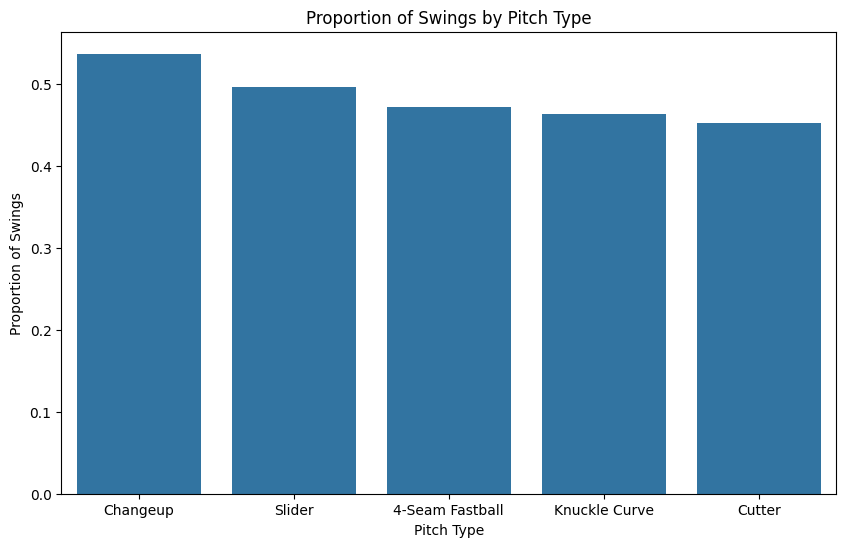

In [155]:
# | echo: false
# | lightbox: true

swing_proportions = swing_train.groupby('pitch_name')['swing'].mean().sort_values(ascending=False)
# exploratory visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=swing_proportions.index, y=swing_proportions.values)
plt.title('Proportion of Swings by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('Proportion of Swings')
plt.xticks(rotation=0)
plt.show()

This visualization shows the proportion of each swing type that results in a swing. The most common swing type is a fastball, which has a 0.5 probability of resulting in a swing. The least common swing type is a changeup, which has a 0.3 probability of resulting in a swing.

### Models

In [157]:
# process data for ML

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
num_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
featurs = cat_features + num_features
target = 'swing'

num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]
)

In [158]:
# train models
# create a calibrated model

params_grid = {
    "method": [
        "isotonic",
        "sigmoid",
    ],
    "estimator__classifier__max_depth": [5, 10, 15, 25, None],
    "estimator__classifier__criterion": ['log_loss', 'gini'],
}

model = GridSearchCV(CalibratedClassifierCV(estimator=pipeline), cv=5, param_grid=params_grid, n_jobs=-1)
_ = model.fit(X_train, y_train)

In [159]:
model.best_params_

{'estimator__classifier__criterion': 'gini',
 'estimator__classifier__max_depth': 15,
 'method': 'sigmoid'}

We train and tune a random forest classifier model to predict the probability of a batter swinging at a pitch.

## Results

In [169]:
# report model metrics
# function to calculate the calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=10):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_idx = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(bin_idx, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(bin_idx, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(bin_idx, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)

    return calibration_error

test_ece = calibration_error(y_test, model.predict_proba(X_test)[:, 1], type="expected")
test_mce = calibration_error(y_test, model.predict_proba(X_test)[:, 1], type="max")
test_brier = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
accuracy_score = accuracy_score(y_test, model.predict(X_test))
print(f"Test accuracy: {accuracy_score:.4f}")
print(f"Test ECE: {test_ece:.4f}")
print(f"Test MCE: {test_mce:.4f}")
print(f"Test Brier: {test_brier:.4f}")

Test accuracy: 0.7329
Test ECE: 0.0473
Test MCE: 0.1189
Test Brier: 0.1844


In [165]:
# | echo: false
# | output: false
# serialize model
dump(model, "swing.joblib", compress=8)


['swing.joblib']

## Discussion

I would recommend against the use of this model in a production setting. The test accuracy of the model is around 73%, which is not that great. In terms of calibration, the model is also not very well calibrated, according to the calibration plot below. It acheives decent ECE, MCE, and Brier scores, but the calibration plot still shows that the model is far from being a perfectly calibrated model.

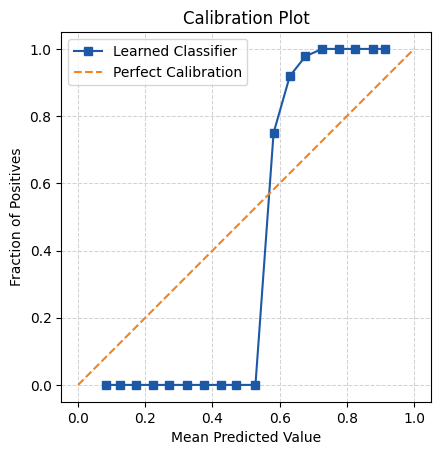

In [166]:
# | echo: false
# | lightbox: true
# summary figure
# function to plot a calibration_plot
def plot_calibration_plot(y_true, y_prob):

    # generate "data" for calibration plot
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_prob,
        n_bins=20,
        pos_label=1,
    )

    # create a figure and axis object with a specific size
    fig, ax = plt.subplots()

    # plot the calibration curve
    ax.plot(
        prob_pred,
        prob_true,
        "s-",
        label="Learned Classifier",
        color="#1D58A7",
    )

    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="#F5821E",
    )

    # set the plot title and axis labels
    ax.set_title("Calibration Plot")
    ax.set_xlabel("Mean Predicted Value")
    ax.set_ylabel("Fraction of Positives")

    # add a grid
    ax.grid(
        True,
        color="lightgrey",
        linewidth=0.75,
        linestyle="--",
    )

    # fix aspect ratio
    ax.set_aspect(
        "equal",
        adjustable="box",
    )

    # show the legend
    ax.legend()

    # show the plot
    plt.show()

plot_calibration_plot(y_train, model.predict_proba(X_train)[:,1])